In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

In [2]:
druzine = pd.read_csv('../podatki/Kibergrad.csv')
velikost_populacije = druzine.shape[0]
print(velikost_populacije)

43886


In [3]:
druzine

,'TIP','CLANOV','OTROK','DOHODEK','CETRT','IZOBRAZBA'
0,1,2,0,43450,1,39
1,1,2,0,79000,1,40
2,1,2,0,51306,1,39
3,1,4,2,24850,1,41
4,1,4,2,65145,1,43
...,...,...,...,...,...,...
43881,1,5,3,30800,4,36
43882,1,2,0,16684,4,34
43883,1,2,0,12000,4,39
43884,1,2,0,50022,4,34


In [4]:
# Vzamemo 100 enostavnih slučajnih vzorcev družin
n_vzorca = 200
vzorci = [druzine.sample(n_vzorca) for _ in range(100)]

In [5]:
vzorci_otrok = np.array([v["'OTROK'"].to_numpy() for v in vzorci])

In [6]:
# Izračun ocen povprečij števila otrok za vsakega od vzorcev družin
povprecja_otrok = np.mean(vzorci_otrok, axis=1)

# Povprečje ocena povprečja iz prvega vzorca
povprecja_otrok[0]

0.925

In [7]:
# Računanje standardne napake ocene povprečja
N = velikost_populacije
(a, b) = vzorci_otrok.shape

razsirjeno_povprecje = np.transpose(np.resize(povprecja_otrok, (b,a)))
vsota_kvadratov = (vzorci_otrok - razsirjeno_povprecje)**2
vsota_kvadratov = vsota_kvadratov.sum(axis=1)
SE = ((N-1) / N) * (1/(n_vzorca*(n_vzorca-1))) * vsota_kvadratov
SE = np.sqrt(SE)

# Ocena standardne napake za prvi vzorec
SE[0]

0.0808045408955401

In [41]:
# Izračun intervalov zaupanja za izbrane vzorce družin
df = n_vzorca - 1
alpha = 0.05 # je stopnja tveganja
kvantil_t = t.ppf(1-(alpha/2), df)

sirina_intervala = kvantil_t * SE
spodnje_meje = povprecja_otrok - sirina_intervala
zgornje_meje = povprecja_otrok + sirina_intervala
intervali_zaupanja = np.array([spodnje_meje, zgornje_meje]).transpose()

# Interval zaupanja za prvi vzorec
intervali_zaupanja[0]

array([0.76565696, 1.08434304])

In [44]:
# Shranjevanje intervalov zaupanja v datoteko
intervali_zaupanja_df = pd.DataFrame({
    'SPODNJA_MEJA' : spodnje_meje,
    'ZGORNJA_MEJA' : zgornje_meje
})

intervali_zaupanja_df.to_csv('../rezultati/intervali_zaupanja.csv')

In [9]:
# Izračun populacijskega povprečja, standardnega odklona in
# prave standardne napake za enostavne slučajne vzorce velikosti 200
populacija_otrok = druzine["'OTROK'"].to_numpy()
mi_otrok = populacija_otrok.mean()
std_otrok = populacija_otrok.std()
st_napaka_otrok_vzorcev = np.sqrt((N - n_vzorca) / (N - 1) * std_otrok**2 / n_vzorca)

In [21]:
mi_otrok

0.9479332816843641

In [10]:
# Primerjava standardne napake za prvi vzorec
print('Ocena standardne napake: ', SE[0])
print('Prava standardna napaka: ', st_napaka_otrok_vzorcev)

Ocena standardne napake:  0.0808045408955401
Prava standardna napaka:  0.0816404987959038


In [11]:
# Ali interval zapuanja pokrije populacijsko povprečje?
pokrije = intervali_zaupanja[0,0] < mi_otrok and mi_otrok < intervali_zaupanja[0, 1]
if pokrije:
    print('Da, interval zapuanja za prvi vzorec pokrije populacijsko povprečje.')
else:
    print('Ne, interval zapuanja za prvi vzorec ne pokrije populacijskega povprečja.')

Da, interval zapuanja za prvi vzorec pokrije populacijsko povprečje.


Delež intervalov zaupanja, ki pokrivajo populacijsko povprečje, je 0.96


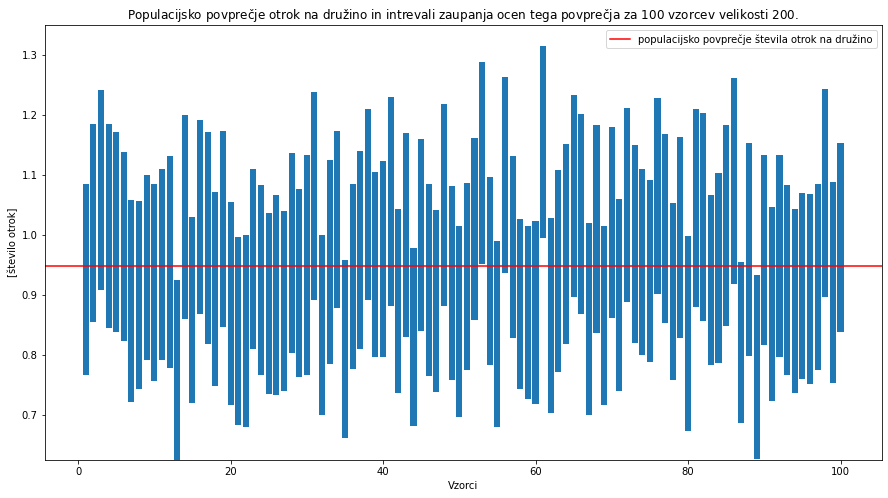

In [12]:
# Grafična primerjava intervalov zaupanja in populacijskega povprečja
fig, ax = plt.subplots(figsize=(15, 8))
x = np.linspace(1, 100, 100)
ax.bar(x, 2*sirina_intervala, bottom=intervali_zaupanja[:, 0])
izris_mi = ax.axhline(mi_otrok, color='r')
izris_mi.set_label('populacijsko povprečje števila otrok na družino')
ax.set_xlabel('Vzorci')
ax.set_ylabel('[število otrok]')
ax.legend()
ax.set_title('Populacijsko povprečje otrok na družino in intrevali zaupanja ocen tega povprečja za $100$ vzorcev velikosti $200$.')
fig.savefig('../rezultati/intervali_zaupanja_100_vzorcev_pop_povprecje.jpg', dpi=150)

# Koliko od intervalov zaupanja izmed stotih vzorcev pokrije populacijsko povprečje?
delez_int_zaup_z_mi = (intervali_zaupanja[:, 0] < mi_otrok) == (mi_otrok < intervali_zaupanja[:, 1])
delez_int_zaup_z_mi = delez_int_zaup_z_mi.astype(int).sum() / 100
print('Delež intervalov zaupanja, ki pokrivajo populacijsko povprečje, je', delez_int_zaup_z_mi)

In [23]:
# Standardni odklon ocen povprečij
n = povprecja_otrok.shape[0]
std_povprecij = 1 / (n-1) * ((povprecja_otrok - povprecja_otrok.mean())**2).sum()
std_povprecij = np.sqrt(std_povprecij)

print('Standardni odklon ocen povprečij je', std_povprecij)
print('Prava standardna napaka za vzorec velikosti 200 je', st_napaka_otrok_vzorcev)

Standardni odklon ocen povprečij je 0.07762926658357033
Prava standardna napaka za vzorec velikosti 200 je 0.0816404987959038


In [14]:
# Vzorci velikosti 800
n_vzorca_1 = 800
vecji_vzorci = [druzine.sample(n_vzorca_1) for _ in range(100)]
vecji_vzorci_otrok = np.array([v["'OTROK'"].to_numpy() for v in vecji_vzorci])

In [15]:
# Računanje ocen povprečja in standardne napake
N = velikost_populacije
(a, b) = vecji_vzorci_otrok.shape

povprecja_otrok_1 = np.mean(vecji_vzorci_otrok, axis=1)

razsirjeno_povprecje = np.transpose(np.resize(povprecja_otrok_1, (b,a)))
vsota_kvadratov = (vecji_vzorci_otrok - razsirjeno_povprecje)**2
vsota_kvadratov = vsota_kvadratov.sum(axis=1)
SE_1 = ((N-1) / N) * (1/(n_vzorca_1*(n_vzorca_1-1))) * vsota_kvadratov
SE_1 = np.sqrt(SE)

In [39]:
# Ocene povprečij in standardne napake za večje vzorce
df = n_vzorca_1 - 1
alpha = 0.05 # je stopnja tveganja
kvantil_t = t.ppf(1-(alpha/2), df)

sirina_intervala_1 = kvantil_t * SE_1
spodnje_meje_1 = povprecja_otrok_1 - sirina_intervala_1
zgornje_meje_1 = povprecja_otrok_1 + sirina_intervala_1
intervali_zaupanja_1 = np.array([spodnje_meje_1, zgornje_meje_1]).transpose()

In [45]:
# Shranjevanje intervalov zaupanja v datoteko
intervali_zaupanja_df_1 = pd.DataFrame({
    'SPODNJA_MEJA' : spodnje_meje_1,
    'ZGORNJA_MEJA' : zgornje_meje_1
})

intervali_zaupanja_df_1.to_csv('../rezultati/intervali_zaupanja_1.csv')

Delež intervalov zaupanja, ki pokrivajo populacijsko povprečje, je 1.0


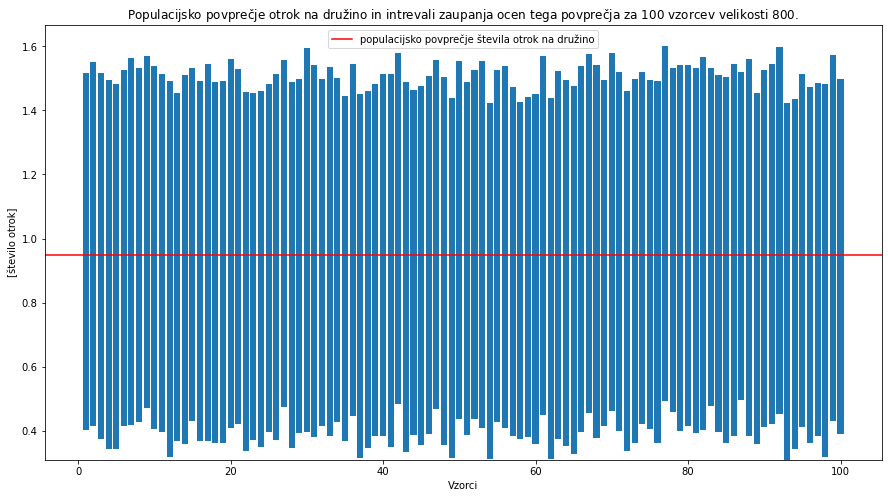

In [40]:
# Grafična primerjava intervalov zaupanja in populacijskega povprečja
fig, ax = plt.subplots(figsize=(15, 8))
x = np.linspace(1, 100, 100)
ax.bar(x, 2*sirina_intervala_1, bottom=intervali_zaupanja_1[:, 0])
izris_mi = ax.axhline(mi_otrok, color='r')
izris_mi.set_label('populacijsko povprečje števila otrok na družino')
ax.set_xlabel('Vzorci')
ax.set_ylabel('[število otrok]')
ax.legend()
ax.set_title('Populacijsko povprečje otrok na družino in intrevali zaupanja ocen tega povprečja za $100$ vzorcev velikosti $800$.')
fig.savefig('../rezultati/intervali_zaupanja_100_vecjiih_vzorcev_pop_povprecje.jpg', dpi=150)

# Koliko od intervalov zaupanja izmed stotih vzorcev pokrije populacijsko povprečje?
delez_int_zaup_z_mi_1 = (intervali_zaupanja[:, 0] < mi_otrok) == (mi_otrok < intervali_zaupanja[:, 1])
delez_int_zaup_z_mi_1 = delez_int_zaup_z_mi_1.astype(int).sum() / 100
print('Delež intervalov zaupanja, ki pokrivajo populacijsko povprečje, je', delez_int_zaup_z_mi_1)

In [46]:
# Standardni odklon ocen povprečij
n = povprecja_otrok_1.shape[0]
std_povprecij_1 = 1 / (n-1) * ((povprecja_otrok_1 - povprecja_otrok_1.mean())**2).sum()
std_povprecij_1 = np.sqrt(std_povprecij_1)

st_napaka_otrok_vzorcev_1 = np.sqrt((N - n_vzorca_1) / (N - 1) * std_otrok**2 / n_vzorca_1)

print('Standardni odklon ocen povprečij je', std_povprecij_1)
print('Prava standardna napaka za vzorec velikosti 800 je', st_napaka_otrok_vzorcev_1)

Standardni odklon ocen povprečij je 0.039896241294693977
Prava standardna napaka za vzorec velikosti 800 je 0.040538959874385


In [19]:
# Primerjava deležev pokritja populacijskega povprečja in standardnih odklonov
print('Delež pokritja populacijskega povprečja za vzorce velikosti 200 je', delez_int_zaup_z_mi)
print('Delež pokritja populacijskega povprečja za vzorce velikosti 800 je', delez_int_zaup_z_mi_1)



Delež pokritja populacijskega povprečja za vzorce velikosti 200 je 0.96
Delež pokritja populacijskega povprečja za vzorce velikosti 800 je 1.0
